In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

Function definitions. One Function per cell

In [2]:
# Time wrapper function
def time_it(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} executed in {end_time - start_time} seconds")
        return result
    return wrapper

In [3]:
# Cell filtering and QC for UMAP
def filter_cells_for_UMAP(data, min_gen = 500, min_cell = 3, mt_pct = 60, normed = 0, doublet_threshold = 0.24, min_ct = 0, max_genes = 0): #min_ct is removed. Consider restoring it later. You will find it commented out below. Max genes is also removed and commented even further below
    # Working default arguments:
    # data, min_gen = 500, min_cell = 3, mt_pct = 60, normed = 0, doublet_threshold = 0.24, min_ct = 0, max_genes = 0
    adata = data # This is to avoid writing into the file that's entered as an argument
    if min_ct > 0:
        sc.pp.filter_cells(adata, min_counts = min_ct) # Filter cells based on number of RNA reads
    sc.pp.filter_cells(adata, min_genes= min_gen) # Filter cells based on the number of recognized genes
    sc.pp.filter_genes(adata, min_cells = min_cell) # Filter genes based on the minimum number of cells expressing it
    adata_prefilt = adata[adata.obs['doublet_scores'] < doublet_threshold]
    if max_genes > 0:
        adata_prefilt = adata_prefilt[adata_prefilt.obs['n_genes_by_counts'] < max_genes]
        
    if not normed:
        adata_filt = adata_prefilt[adata_prefilt.obs['pct_counts_mt'] < mt_pct] # Filtering based on percentage of mitochondrial genes
    else:
        adata_filt = adata_prefilt
    return adata_filt    

In [4]:
# Processing for UMAP from QC all the way to the end
@time_it # Timing wrapper for benchmarking purposes. Can comment out
def process_for_UMAP(data, normed = 0, leiden_res = 0.8, filtering = 1, min_gen = 500, min_cell = 3, mt_pct = 60, neighbors = 50): # DEFAULT QC VALUES
    # Working default arguments:
    # data, normed = 0, leiden_res = 0.8, filtering = 1, min_gen = 500, min_cell = 3, mt_pct = 60, neighbors = 15
    adata = data # This is to avoid writing into the file that's entered as an argument
    if filtering:
        adata_filt = filter_cells_for_UMAP(data = adata, min_gen = min_gen, min_cell = min_cell, mt_pct = mt_pct) #min ct is removed. Think about restoring it later.
    else:
        adata_filt = adata       
    sc.pp.normalize_total(adata_filt, target_sum=1e4) # Normalize
    sc.pp.log1p(adata_filt) # Log scaling
    sc.pp.highly_variable_genes(adata_filt, min_mean = 0.0125, max_mean = 3, min_disp = 0.5) # Compute differentially expressed genes within the sample
    adata_filt.raw = adata_filt # Store the raw files in its own layer
    #adata_filt = adata_filt[:, adata_filt.var.highly_variable] # Filter on genes that are highly variable
    sc.pp.regress_out(adata_filt, ['total_counts', 'pct_counts_mt']) # Regression. Not sure what that is.
    sc.pp.scale(adata_filt, max_value = 10) # Scale the data
    sc.tl.pca(adata_filt, svd_solver='arpack') # Compute PCA
    sc.tl.tsne(adata_filt) # Calculate tsne
    sc.pp.neighbors(adata_filt, n_neighbors = neighbors) # Calculate neighbors
    sc.tl.leiden(adata_filt, resolution = leiden_res) # Calculate Leiden clusters
    sc.tl.paga(adata_filt) # Calculate PAGA
    sc.pl.paga(adata_filt, plot = 1)  # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.umap(adata_filt, init_pos='paga') # Plot PAGA
    sc.tl.umap(adata_filt) # Calculate UMAP
    sc.pl.umap(adata_filt, color = ['leiden']) # Plot UMAP and show Leiden clusters
    return adata_filt

In [5]:
# Isolating cells by gene expression. It uses the value as-is so if it's normalized it'll use it
def isolate_cells_by_gene(data, gene, threshold):
    # Now subset_ant_mt_filt contains only the highly variable genes
    data_subset = data[data[:, gene].X > threshold]
    return data_subset

In [6]:
# This function filters the leiden clusters that are positive for a specified gene
# diff is boolean specifying if differential expresion is already done
# Default assumes you didn't do your ranked gene expression analysis
# Default method is kept as the default method for the function
# threshold is the threshold of expression
def filter_clusters_by_gene(data, gene, threshold = 0.5, diff = 0, method = None):
    # Load your AnnData object
    adata = data
    if diff == 0:
        sc.tl.rank_genes_groups(adata, groupby = 'leiden', method = method)
    # Extract the DataFrame for the differential expression results
    de_results = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
    # Define a threshold for significant expression (adjust as needed)
    expression_threshold = threshold
    # Find clusters with significant gene expression
    significant_clusters = []
    for cluster in de_results.columns:
        gene_presence = de_results[cluster].str.contains(gene)
        gene_expression = adata.uns['rank_genes_groups']['logfoldchanges'][cluster][gene_presence]
        if any(gene_expression >= expression_threshold):
            significant_clusters.append(cluster)
    # Subset the data to include only cells from the significant clusters
    adata_subset = adata[adata.obs['leiden'].isin(significant_clusters)].copy()
    return adata_subset

In [7]:
# This function makes a density scatter plot like what one might see with flow analysis.
# The X and Y axes defaults are specified to my specific use, but they can be changed
def scatter_density_plot(data, background = 'grey', cmap = 'hsv', upxlim = None, loxlim = None, upylim = None, loylim = None, size = None, bw_adjust = 0.5, x = 'Gastric stemness', y = 'Intestinal stemness'):
    # Extract the data from the AnnData object
    x_data = data.obs[x].values
    y_data = data.obs[y].values
    
    # Creating the density plot
    plt.figure()
    
    # Set the axes
    plt.xlim(loxlim, upxlim);
    plt.ylim(loylim, upylim);
    
    # Create the base scatter plot
    plt.scatter(x_data, y_data, c = 'gray', s = size, edgecolor='none')

    # Create the heatmap on top    
    sns.kdeplot(x = x_data, y = y_data, cmap = "hsv", shade=True, bw_adjust = bw_adjust)
    
    # Label the axes
    plt.xlabel(x)
    plt.ylabel(y)
    
    # Show the plot
    plt.show()
    
    return(plt)

In [8]:
# Function for mapping names to columns
# Must create the mapping set and feed it here
def map_to_column(data, map_set, column = 'Localization'):
    data.obs[column + '_old'] = data.obs[column]
    data.obs[column] = data.obs[column].map(map_set)
    print(data.obs[column])
    print(data.obs[column + '_old'])
    return 'Mapping function done'

Setting up the environmental and misc variables alongside starting the timer to measure script execution time

In [9]:
# Execution start begin with timing
start_time = time.time()
sc.settings.verbosity = 3
fig_res = 150
sc.set_figure_params(dpi = fig_res, frameon = 0)

# MIK67 = Ki67, TNSFRSF19 = TROY
gastric_stem = ['LGR5', 'ASCL2', 'CD44', 'STMN1', 'BMI1', 'LRIG1', 'TNFRSF19', 'SOX2']
intestinal_stem = ['SMOC2', 'OLFM4']
stem = gastric_stem + intestinal_stem # Currently, this is an overall list of all the markers used to look at any stem cells in either the intestines or the stomach.

inspect_stem = ['leiden', 'MKI67', 'LGR5', 'ASCL2', 'CD44', 'SMOC2', 'STMN1', 'OLFM4', 'BMI1', 'LRIG1', 'BHLHA15', 'TNFRSF19', 'SOX2', 'leiden', 'Localization']
inspect_stem_duo = ['leiden', 'MKI67', 'LGR5', 'ASCL2', 'CD44', 'SMOC2', 'STMN1', 'OLFM4', 'BMI1', 'LRIG1', 'leiden', 'Localization']

inspect_stem_gast = ['leiden', 'MKI67', 'LGR5', 'TNFRSF19', 'ASCL2', 'CD44', 'SMOC2', 'SOX2', 'STMN1', 'OLFM4', 'BMI1', 'LRIG1', 'leiden', 'Localization']

gastric_markers = ['leiden', 'MKI67', 'LGR5', 'TNFRSF19', 'BHLHA15', 'ASCL2', 'CD44', 'SMOC2', 'SOX2', 'STMN1', 'OLFM4', 'BMI1', 'LRIG1', 'MUC6', 'TFF2', 'MUC5AC', 'GKN2', 'TFF1', 'GHRL', 'AQP5', 'MUC1', 'leiden', 'Localization']
duodenal_markers = ['leiden', 'MKI67', 'LGR5', 'TNFRSF19', 'BHLHA15', 'ASCL2', 'CD44', 'SMOC2', 'SOX2', 'STMN1', 'OLFM4', 'BMI1', 'LRIG1', 'MUC6', 'MUC2', 'TFF3', 'GHRL', 'AQP5', 'MUC1', 'ANPEP', 'LYZ', 'leiden', 'Localization']

global_res = 0.5

In [10]:
all_org_harmony = sc.read_h5ad('S:/data cache/code_in_out/agr2/agr2_init_files/agr2_nneigh30_pcs75_dir/agr2_bcharmony_meteuclidean_neighbors.h5ad')

In [11]:
str(all_org_harmony)

"AnnData object with n_obs × n_vars = 24486 × 1773\n    obs: 'sample_id', 'SampleID', 'Patient', 'Biopsies', 'Site', 'Inflammation', 'Age', 'Sex', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ig', 'pct_counts_ig', 'S_score', 'G2M_score', 'phase', 'cellbarcode', 'n_genes'\n    var: 'gene_ids', 'feature_types', 'hb', 'ig', 'rp', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'hvg_exclude', 'gene_name', 'mean', 'std'\n    uns: 'hvg', 'neighbors', 'pca', 'sample_id_colors', 'umap'\n    obsm: 'X_harmony', 'X_pca', 'X_umap'\n    varm: 'PCs'\n    obsp: 'connectivities', 'distances'"

C:\anaconda_envs\spyder\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


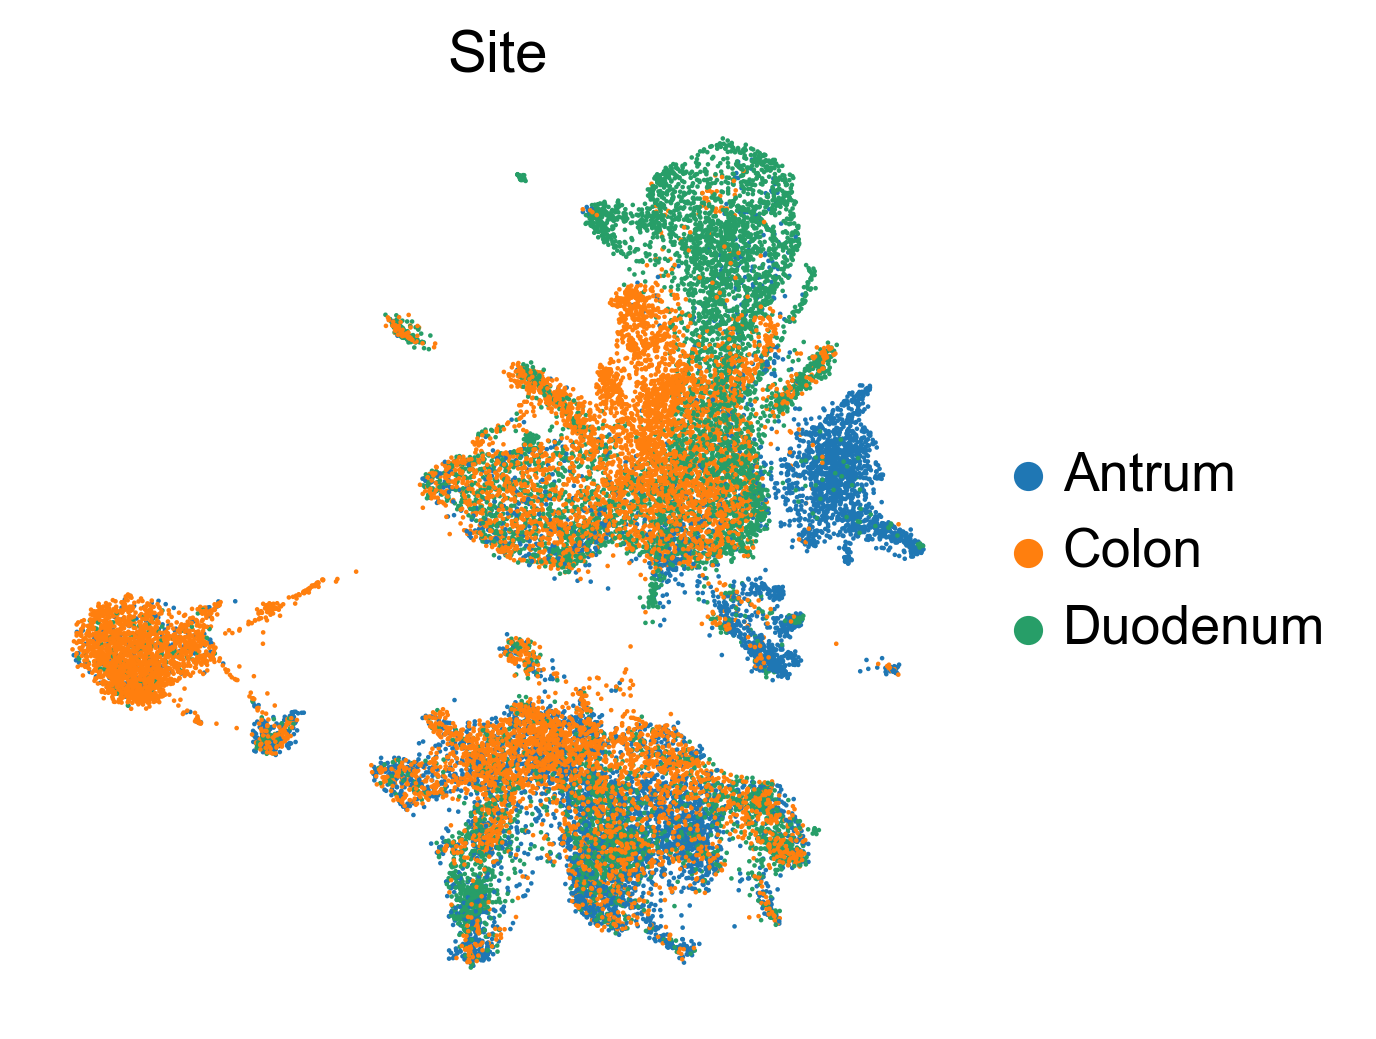

In [12]:
sc.pl.umap(all_org_harmony, color = 'Site')

In [13]:
antrum = all_org_harmony[all_org_harmony.obs['Site'] == 'Antrum']

In [14]:
sc.tl.leiden(antrum, resolution = 0.3)

running Leiden clustering
    finished: found 61 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


C:\anaconda_envs\spyder\Lib\site-packages\scanpy\tools\_leiden.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


C:\anaconda_envs\spyder\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


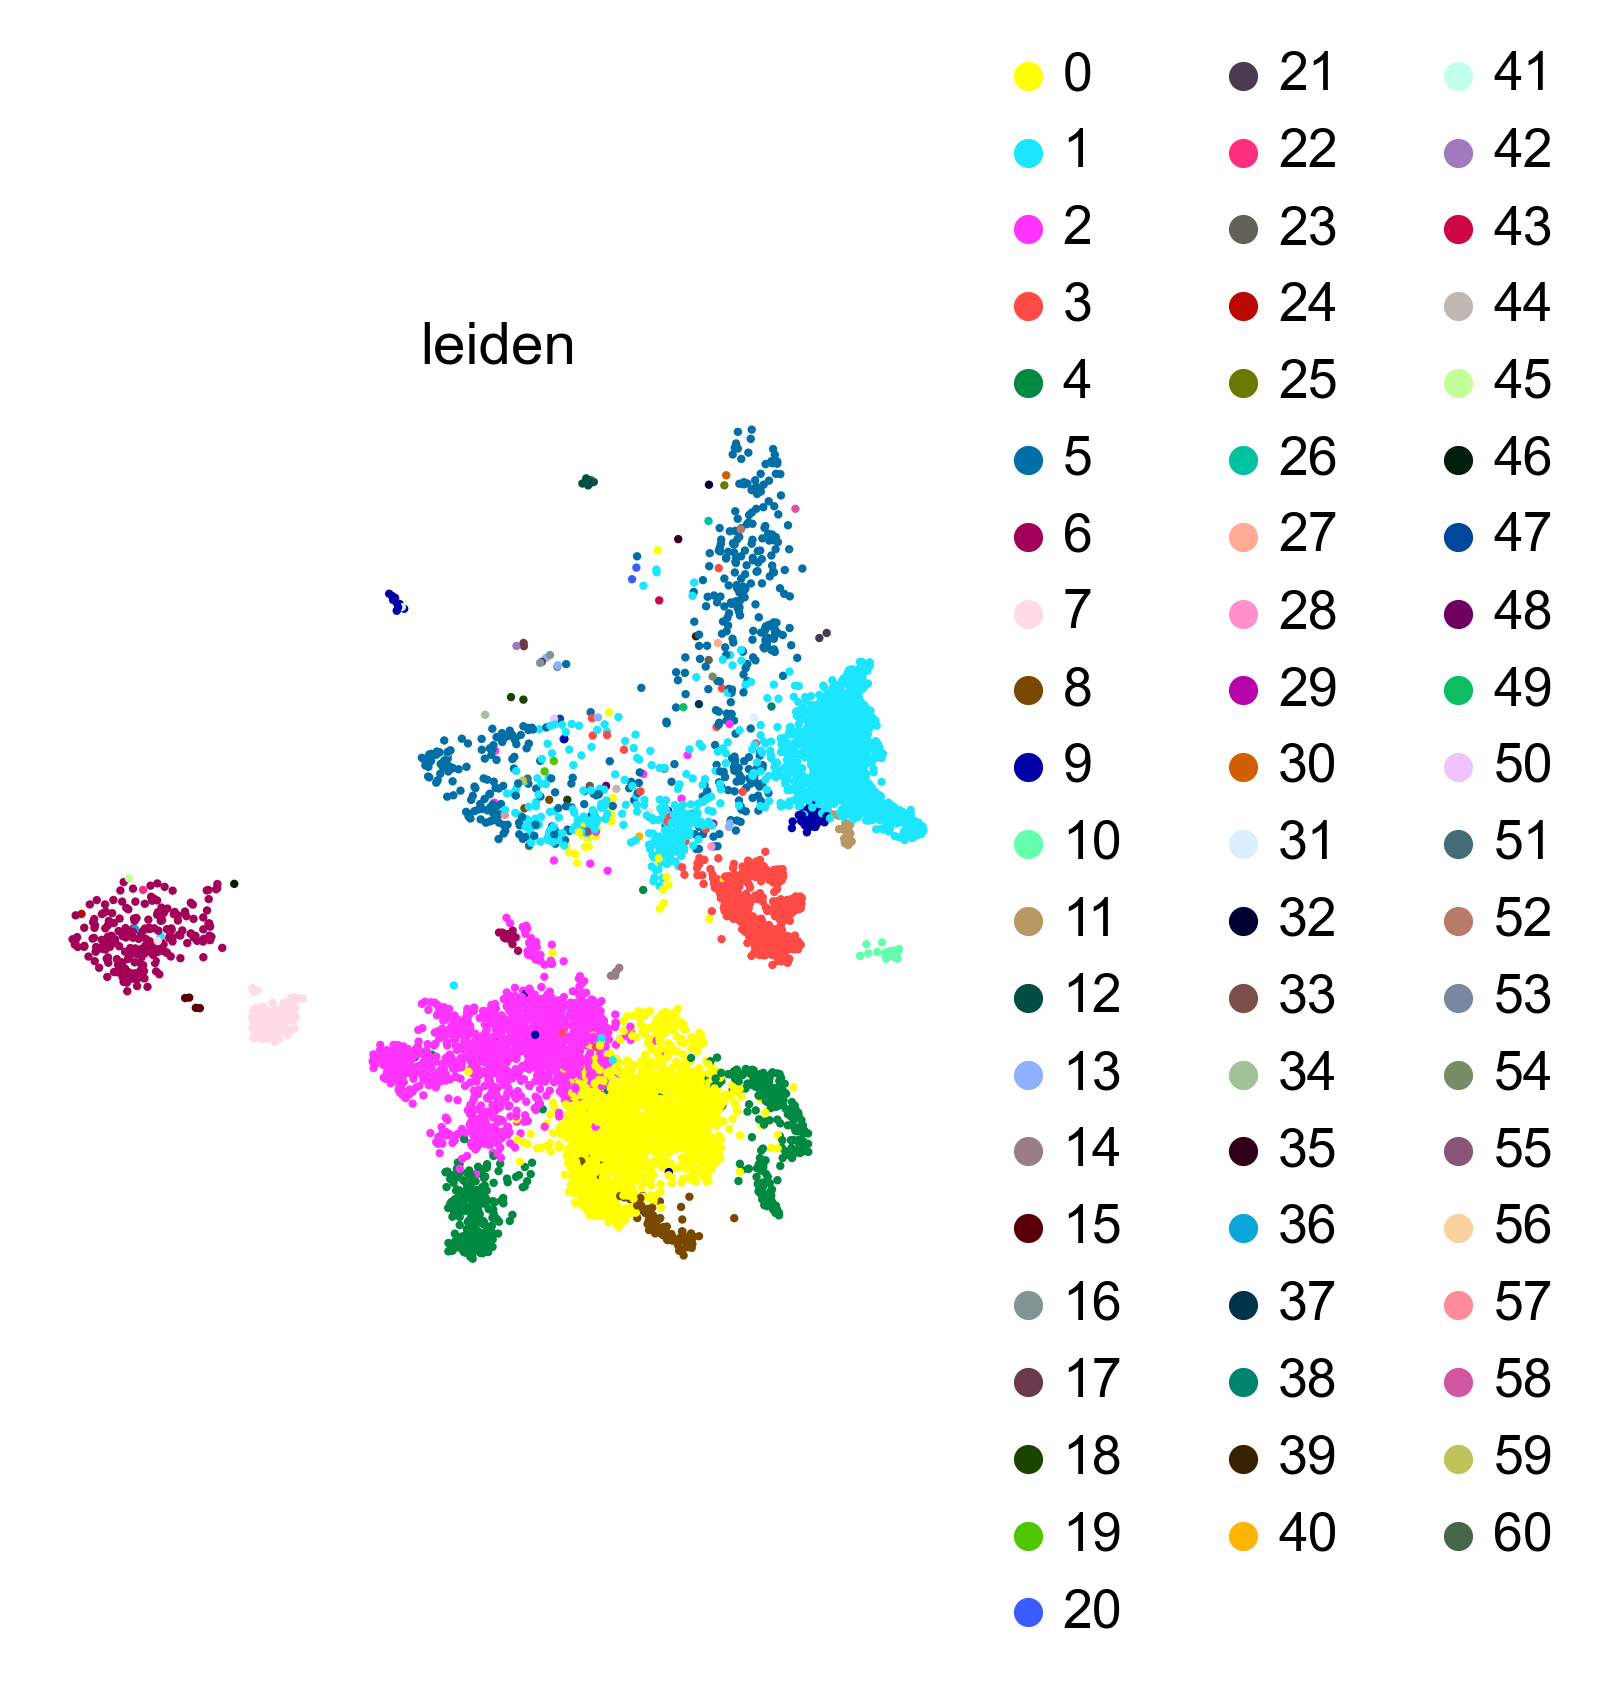

In [15]:
sc.pl.umap(antrum, color = 'leiden')

In [16]:
import scanpy as sc
import pandas as pd

# Assuming your AnnData object is `antrum` and Leiden clustering has already been done
# Minimum number of cells required to keep a cluster
min_cells_per_cluster = 2

# Check the size of each cluster
cluster_sizes = antrum.obs['leiden'].value_counts()

# Identify clusters with at least the minimum number of cells
valid_clusters = cluster_sizes[cluster_sizes >= min_cells_per_cluster].index

# Filter the AnnData object to keep only cells from valid clusters
antrum_filtered = antrum[antrum.obs['leiden'].isin(valid_clusters), :]

# Optional: Verify the filtered clusters
print(antrum_filtered.obs['leiden'].value_counts())


0     1933
1     1740
2     1431
3      610
4      489
5      470
6      241
7      154
8      103
9       79
10      45
11      30
12       7
13       5
14       4
15       4
16       3
17       3
18       3
19       2
20       2
21       2
Name: leiden, dtype: int64


C:\anaconda_envs\spyder\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


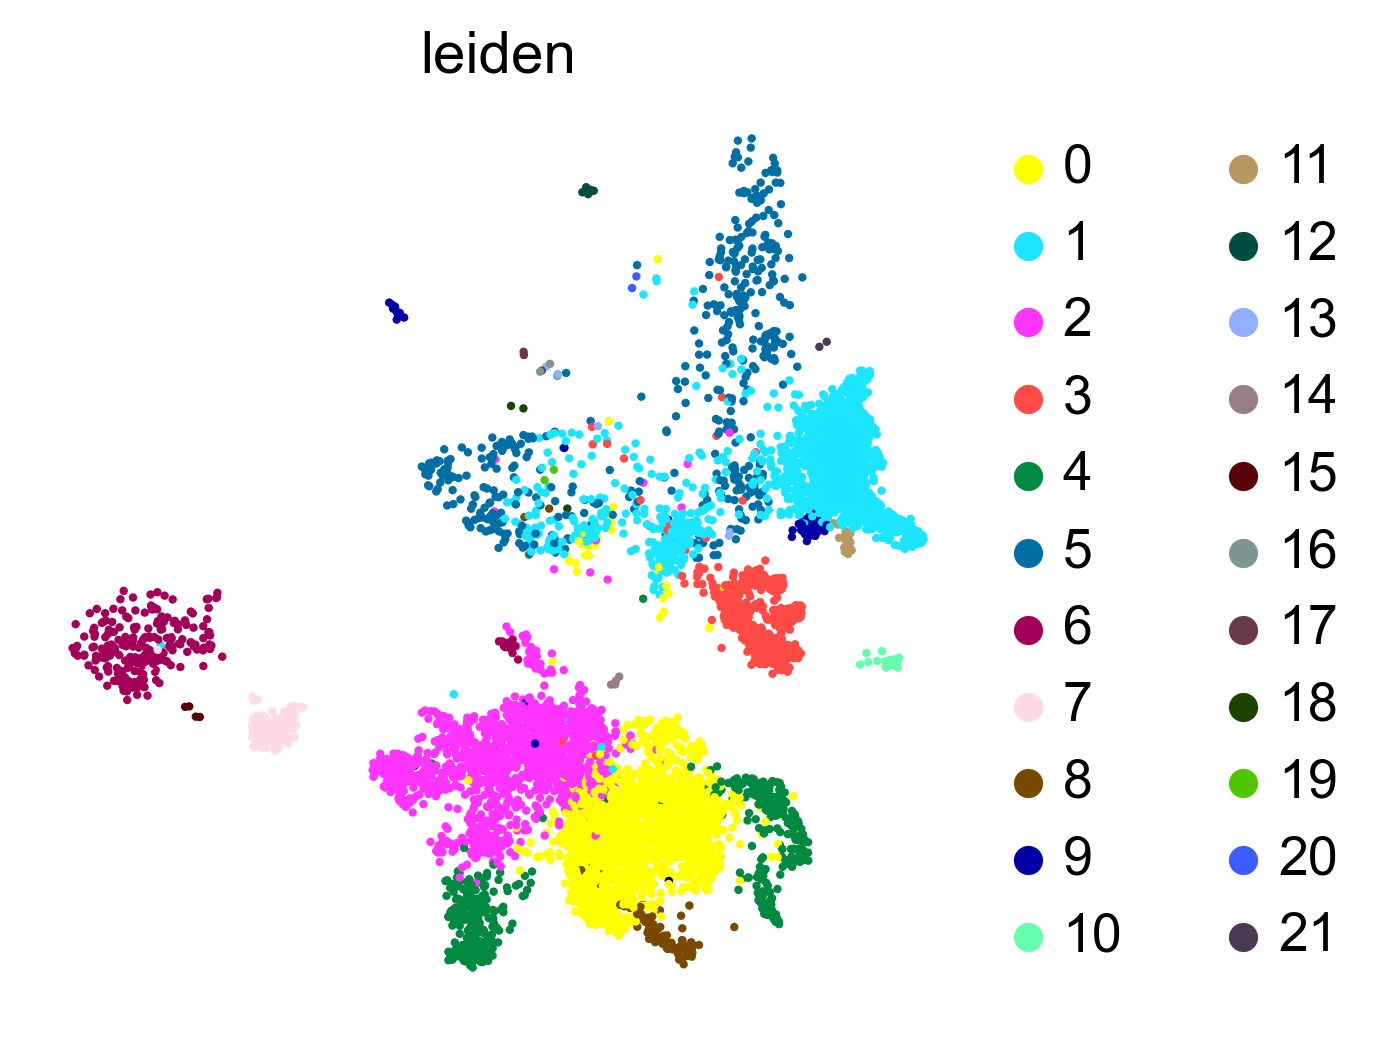

In [27]:
sc.pl.umap(antrum_filtered, color = ['leiden'])

C:\anaconda_envs\spyder\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


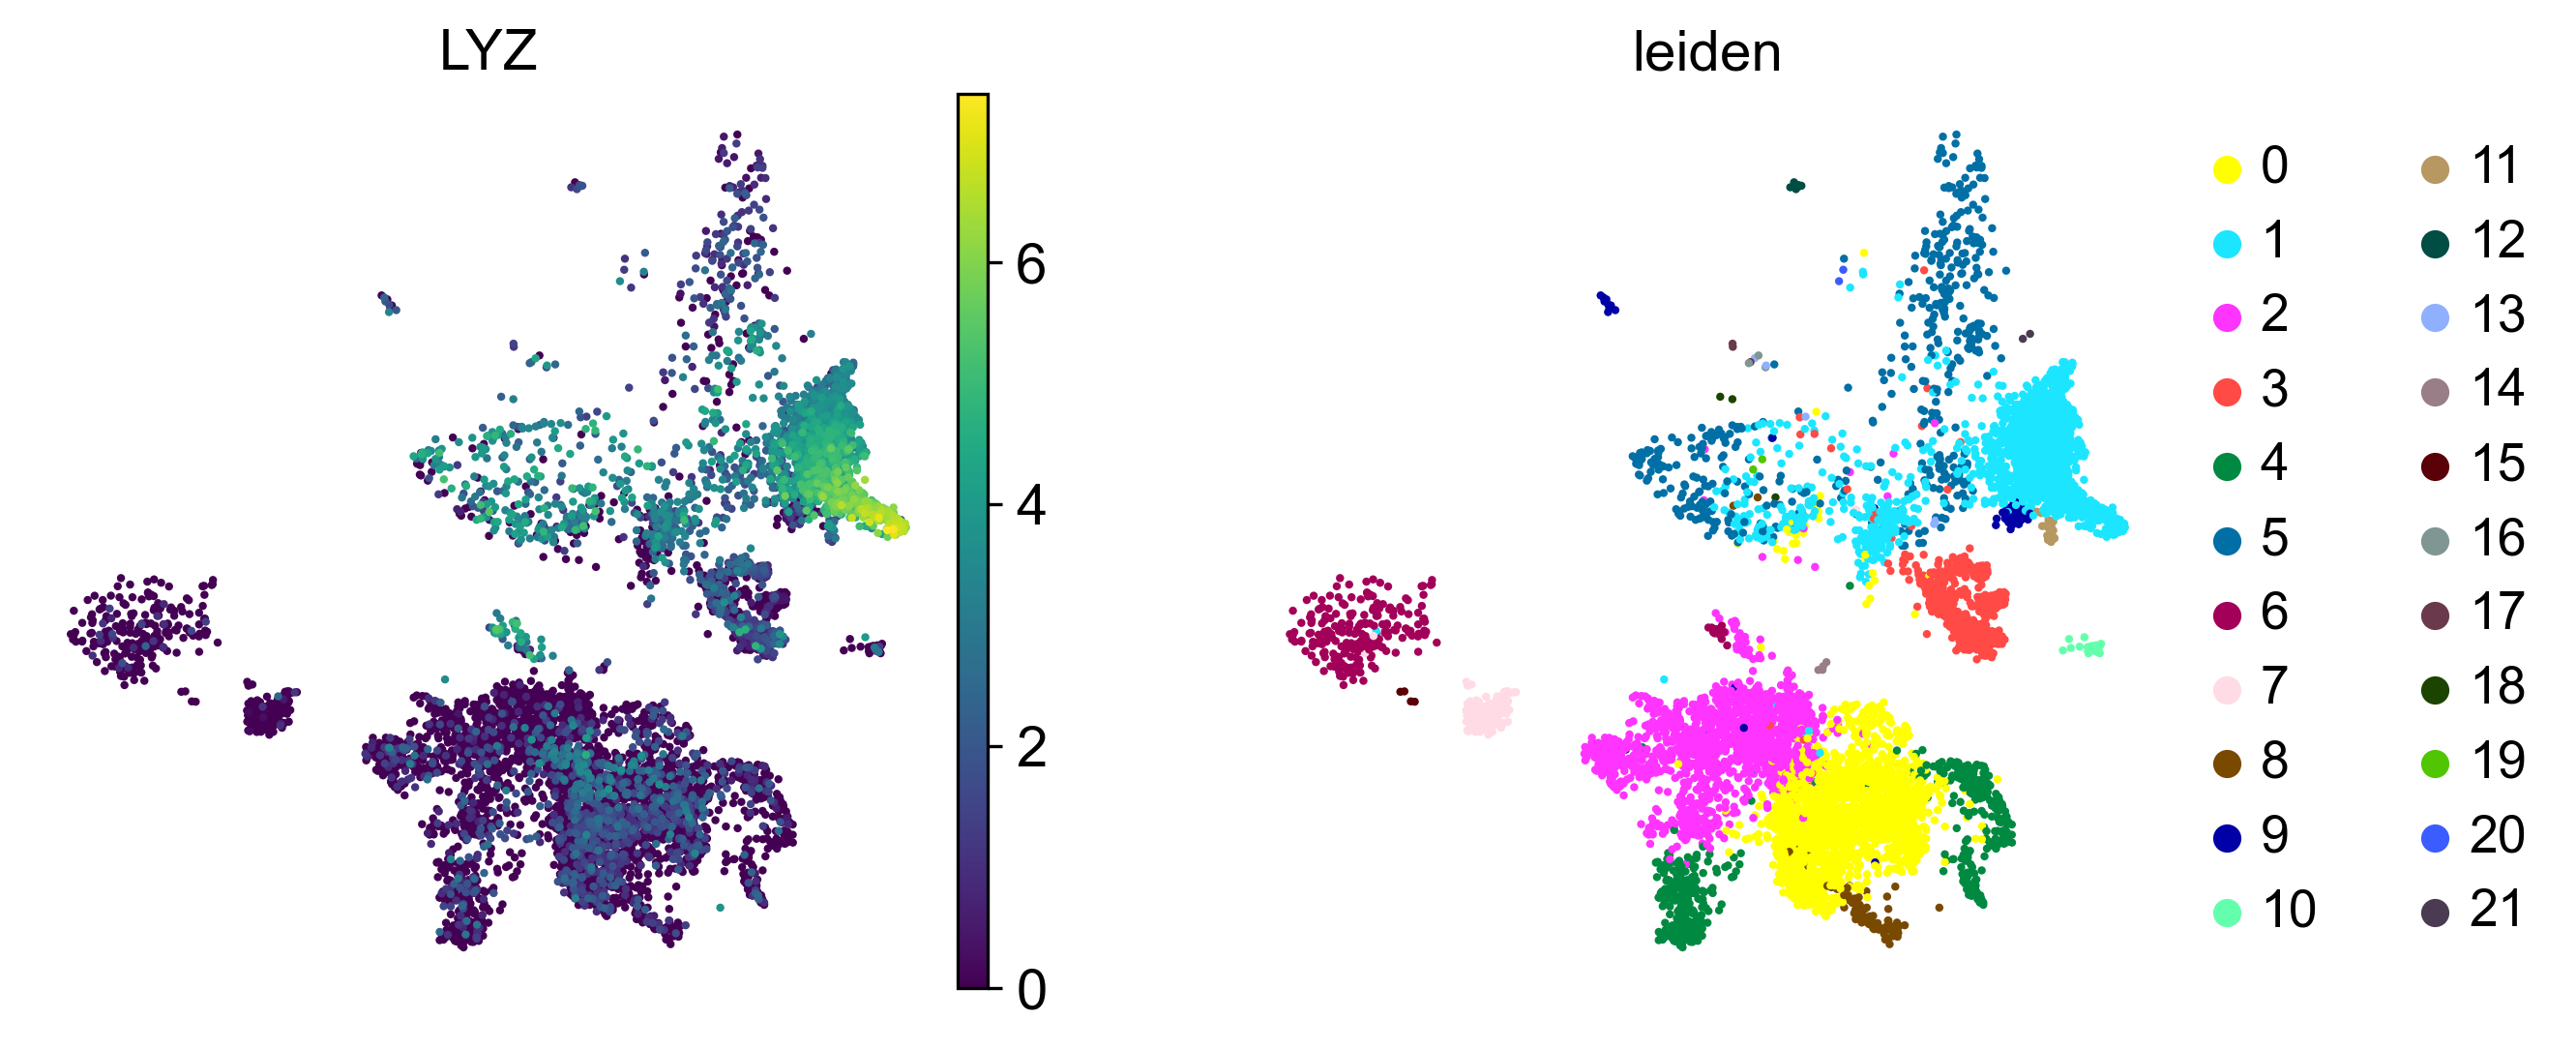

In [26]:
sc.pl.umap(antrum_filtered, color = ['LYZ','leiden'])

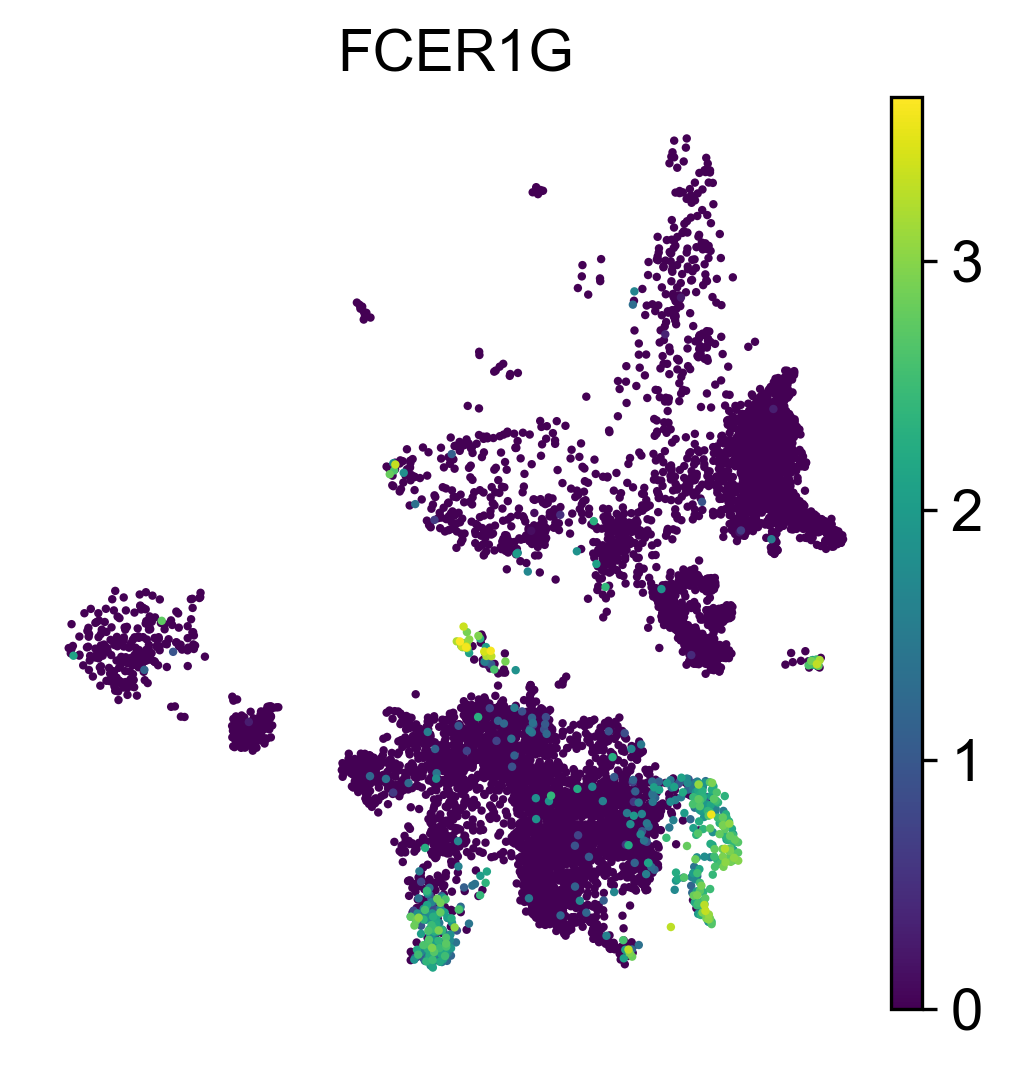

In [18]:
sc.pl.umap(antrum_filtered, color = 'FCER1G')

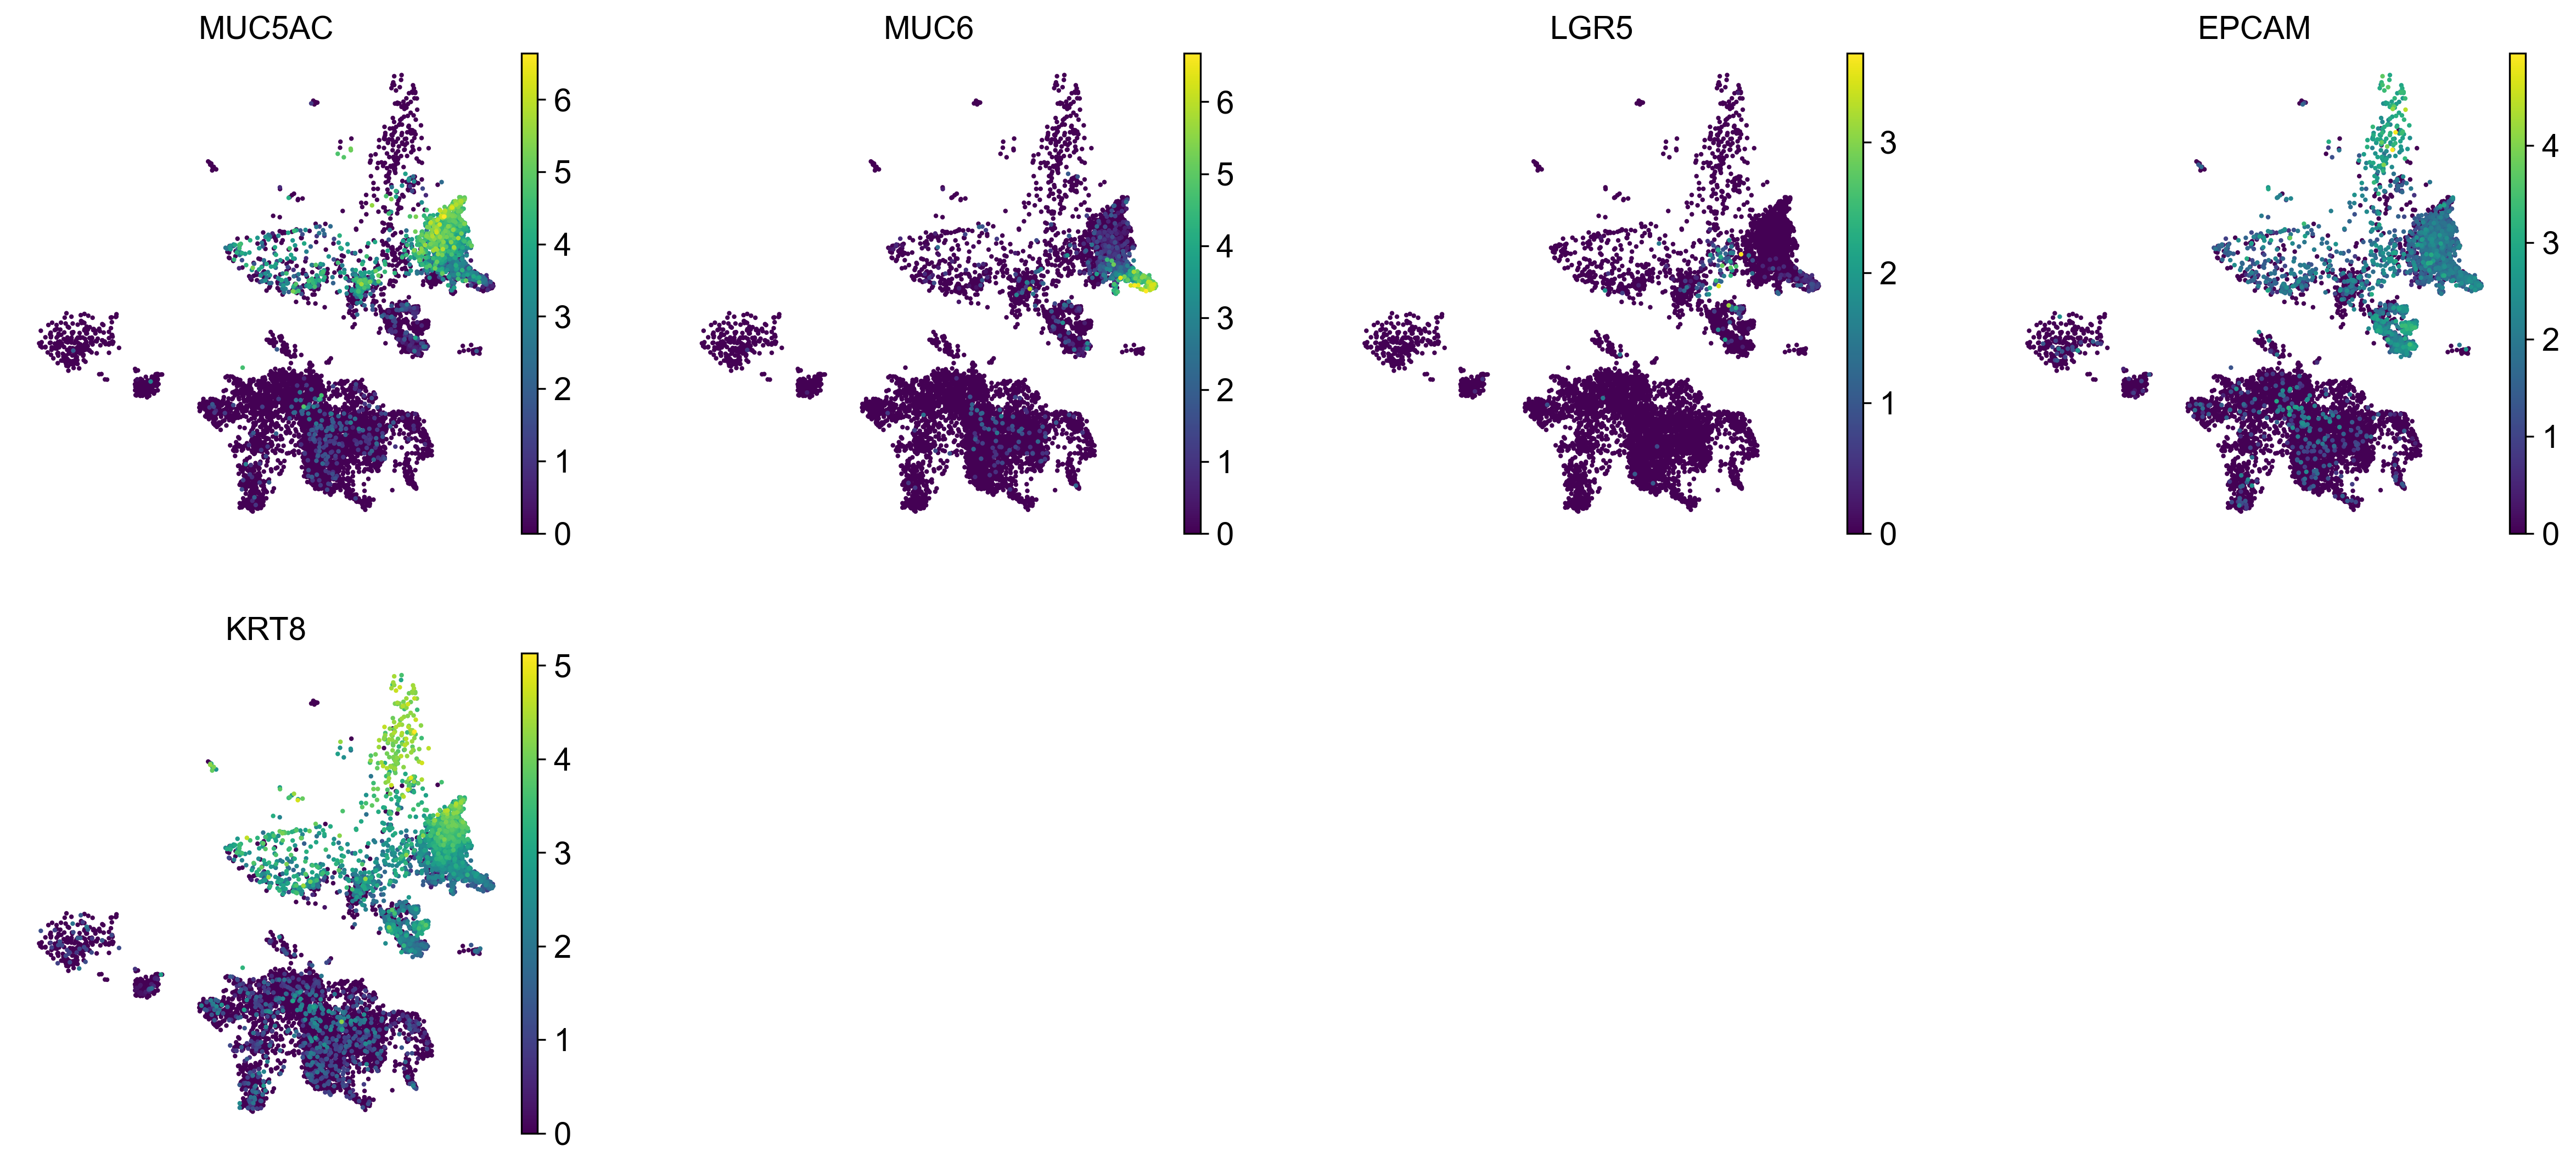

In [19]:
sc.pl.umap(antrum_filtered, color = ['MUC5AC', 'MUC6', 'LGR5', 'EPCAM', 'KRT8'])

In [20]:
sc.tl.rank_genes_groups(antrum_filtered, method = 'wilcoxon', groupby = 'leiden')

ranking genes


C:\anaconda_envs\spyder\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:12)


C:\anaconda_envs\spyder\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\anaconda_envs\spyder\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\anaconda_envs\spyder\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

In [22]:
import pandas as pd

# Specify the directory where you want to save the CSV files
export_path = 'S:/data cache/code_in_out/agr2/script_4_out/'

# Get the ranked genes data from `antrum_filtered.uns`
ranked_genes = antrum_filtered.uns['rank_genes_groups']

# Get the cluster/group names (keys) from the ranking
cluster_names = ranked_genes['names'].dtype.names

# For each cluster, create a DataFrame and export it to a CSV file
for cluster in cluster_names:
    # Create a DataFrame for the cluster with gene names, log fold changes, p-values, etc.
    df = pd.DataFrame({
        'gene': ranked_genes['names'][cluster],
        'logfoldchanges': ranked_genes['logfoldchanges'][cluster],
        'pvals': ranked_genes['pvals'][cluster],
        'pvals_adj': ranked_genes['pvals_adj'][cluster],
        'scores': ranked_genes['scores'][cluster]
    })
    
    # Save the DataFrame to a CSV file for the current cluster
    df.to_csv(f'{export_path}leiden_cluster_{cluster}_differential_expression.csv', sep=',', index=False)


Clusters so far:

Cluster 0: CD8 T cells
CD3, CD28, CD8

Cluster 1: [Epithelial] Gastric mucus producing cells
KRT8, EPCAM, MUC5AC, MUC6, LYZ

Cluster 2: CD4 T cells
CD3, CD28, CD4

Cluster 3: [Epithelial] Neuroendocrine cell
CHGA, PCSK1N, SCG5, SCG3

Cluster 4: Maybe mast or NK. Likely Mast.

Cluster 5: [Epithelial] Intestinal epithelial cells
KRT8, EPCAM, CDX1, AGR2, ANPEP

Cluster 6: B-cells
CD19, CD22, MS4A1, VPREB3

Cluster 7: Plasma cells
JCHAIN, MZB1, FCRL5, DERL3

Cluster 8: NK cells
NKG7, CST7, GZMH, GZMA, GZMB,

Cluster 9: [Epithelial] Some kind of epithelial cell
AQP4, KRT18, and other markers localiza to both endothelial and epithelial cells 

Cluster 10: Mast cells
CPA3, TPSB2, TPSAB1, 

Cluster 11: Chief cells
PGA3, LIPF, PGC, PGA4, PGA5, 

Cluster 12: Endothelial cells
ECSCR, CLDN5, IFITM3